In [ ]:
from tqdm import tqdm, tnrange, tqdm_notebook
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import pickle
import json
import gdown
import h5py
import faiss

%matplotlib inline

In [ ]:
# ! pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 10.8 MB/s eta 0:00:00


# Seminar 6: kNN index and quantization

## 1. Load embeddings

In [ ]:
file_id = '1-1t1sbQXXyB-qZr-czqv2UJ4E5BQ7McI'
destination = 'lastftm_factors.h5'
download_url = f"https://drive.google.com/uc?id={file_id}"

gdown.download(download_url, destination, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1-1t1sbQXXyB-qZr-czqv2UJ4E5BQ7McI
From (redirected): https://drive.google.com/uc?id=1-1t1sbQXXyB-qZr-czqv2UJ4E5BQ7McI&confirm=t&uuid=3434df9a-85cc-425a-af33-e1ca5fd96b8f
To: /content/lastftm_factors.h5
100%|██████████| 333M/333M [00:04<00:00, 72.4MB/s]


'lastftm_factors.h5'

In [ ]:
h5f = h5py.File('/content/lastftm_factors.h5', 'r')
item_factors = h5f['items'][:]
user_factors = h5f['users'][:]
h5f.close()

In [ ]:
item_factors.shape

(292385, 128)

In [ ]:
user_factors.shape

(358868, 128)

## 2. Neighbours search with FAISS

[Faiss docs](https://faiss.ai/)

In [ ]:
%%time
ip_index = faiss.IndexFlatIP(item_factors.shape[1]) # Create index Exact Search for Inner Product

ip_index.add(item_factors) # Add document embeddings to index
print(ip_index.ntotal)

292385
CPU times: user 56.2 ms, sys: 99.9 ms, total: 156 ms
Wall time: 158 ms


In [ ]:
k = 10  # Choose  10 nearest neighbours
n_users = 1000  # 1000 users is real example of request batch

user_embeddings = user_factors[:n_users]

In [ ]:
%%timeit
# D - distances
# I - indices
D, I = ip_index.search(user_embeddings, k)

2.1 s ± 435 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
D, I = ip_index.search(user_embeddings, k)

In [ ]:
D

array([[1.1410543 , 1.1322321 , 1.1187365 , ..., 1.0320057 , 1.0301973 ,
        1.0179089 ],
       [1.2508918 , 1.249527  , 1.2257144 , ..., 1.1644775 , 1.1519464 ,
        1.1518093 ],
       [1.2452835 , 1.1997979 , 1.1582257 , ..., 1.1171805 , 1.1170992 ,
        1.1122485 ],
       ...,
       [1.2237133 , 1.0526612 , 0.99917495, ..., 0.932238  , 0.91025347,
        0.90891665],
       [1.0920773 , 1.0610857 , 1.0202018 , ..., 0.95341027, 0.93552566,
        0.9275902 ],
       [0.93441296, 0.88703007, 0.87762   , ..., 0.840016  , 0.8347395 ,
        0.8100572 ]], dtype=float32)

In [ ]:
I

array([[150177, 161850, 107119, ...,  46258, 136336, 259874],
       [186566,  86649,  71465, ..., 252956, 250342, 267949],
       [180940, 142885, 120981, ..., 234769, 241312, 186835],
       ...,
       [252512,  73871, 168195, ...,  86649, 117134, 194180],
       [109930, 141240,   1560, ...,  33602, 129520, 237577],
       [ 21090,  69978,  82825, ..., 208398,  22505, 158209]])

Let's compare with vanilla method to find nearest neighbours:

In [ ]:
%%time
product = user_embeddings.dot(item_factors.T)
exact_result = np.argsort(product, axis=1)[:,:-k-1:-1]

CPU times: user 37 s, sys: 1.19 s, total: 38.2 s
Wall time: 37.1 s


In [ ]:
np.equal(I, exact_result).mean()

1.0

## 3. HNSW

<img src="https://drive.google.com/uc?export=view&id=1CZlsisey6UWP5rccRE2QaLuInIUkCM2J" width="500">



**HNSW** (Hierarchical navigable small world) - graph-based approximate nearest neighbor algorithm.

In [ ]:
%%time
neighbours = 10
hnsw_index = faiss.IndexHNSWFlat(item_factors.shape[1], neighbours, faiss.METRIC_INNER_PRODUCT) # Create HNSW index

hnsw_index.add(item_factors) # Add document embeddings to index
print(hnsw_index.ntotal)

292385
CPU times: user 22.2 s, sys: 122 ms, total: 22.3 s
Wall time: 13.2 s


In [ ]:
%%time
D, I = hnsw_index.search(user_embeddings, k)

CPU times: user 50.5 ms, sys: 0 ns, total: 50.5 ms
Wall time: 44.3 ms


In [ ]:
I

array([[255141, 230026,  25917, ..., 256607, 199859, 247960],
       [235136, 108379, 252512, ..., 216080, 164892, 290992],
       [204727, 130425, 281570, ..., 152322, 214322, 267583],
       ...,
       [252512,  73871, 212514, ..., 127243,  80500, 156648],
       [212985, 194180, 261239, ..., 118839, 217901, 127243],
       [185387, 238227, 167716, ...,  38235, 210023, 269329]])

In [ ]:
D

array([[1.0627333 , 0.9298105 , 0.7518682 , ..., 0.65008414, 0.61775047,
        0.5910607 ],
       [1.0613976 , 0.85362786, 0.8348808 , ..., 0.3924284 , 0.33177775,
        0.22483255],
       [0.7008995 , 0.38680217, 0.30533308, ..., 0.24423319, 0.21826768,
        0.20691648],
       ...,
       [1.2237133 , 1.0526614 , 0.9594545 , ..., 0.63830894, 0.5670817 ,
        0.5505355 ],
       [0.88827986, 0.7831606 , 0.7469681 , ..., 0.4639511 , 0.40348294,
        0.36683044],
       [0.85022336, 0.76426476, 0.6473534 , ..., 0.5241612 , 0.5108297 ,
        0.4722155 ]], dtype=float32)

In [ ]:
np.equal(I, exact_result).mean()

0.0043

Algorithm is not tuned for the dataset, so results are poor. But you can find optimal parameters for 99% or even 99.9%.

## 4. Quantization

<img src="https://drive.google.com/uc?export=view&id=15HmMKX6BINpCH9n7AP-JRPYBquSrBtrD" width="700">

In [ ]:
# first coordinates of item embeddings
item_factors[:, 0]

array([0.0010011 , 0.00062381, 0.00162728, ..., 0.0001717 , 0.00095794,
       0.00387271], dtype=float32)

Let's look at distribution of first coordinates:

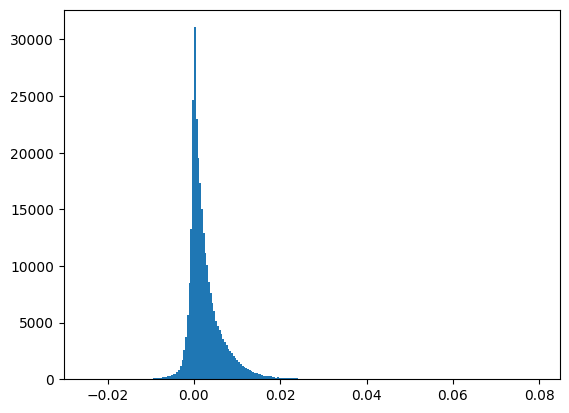

In [ ]:
plt.hist(item_factors[:, 0], bins=255);

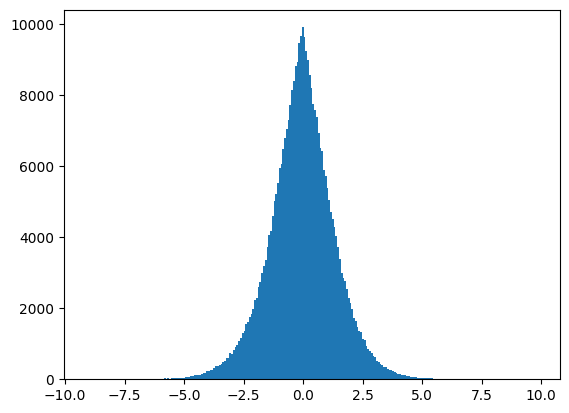

In [ ]:
plt.hist(user_factors[:, 0], bins=255);

### a. Percentile quantizations

**Steps:**
1. **Compute Percentiles**:  
   Divide the embedding values into \(k\) bins (e.g., 256) by calculating percentile values for each dimension.

2. **Quantization**:  
   Map each value in the embeddings to its corresponding bin. Clip the bin indices to the range \([0, k-1]\).

3. **Restoration**:  
   Approximate the original values by replacing each quantized bin index with its corresponding percentile value.


Firstly, let's do it for **items**:

In [ ]:
N = 100000
item_percentiles = []
for perc in tqdm_notebook(np.linspace(0, 100, 256)):
    item_percentiles.append(np.percentile(item_factors[:N, :], perc, axis=0))

<ipython-input-25-e5c56578810d>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for perc in tqdm_notebook(np.linspace(0, 100, 256)):


  0%|          | 0/256 [00:00<?, ?it/s]

In [ ]:
item_percentiles = np.vstack(item_percentiles)

In [ ]:
def perc_quantize(v, percentiles):
    res = []
    for i in range(v.shape[1]):
        res.append(np.digitize(v[:, i], percentiles[:, i]))
    res = np.vstack(res).T
    res = np.clip(res, 0, 255)
    return res

In [ ]:
def perc_restore(q, percentiles):
    res = []
    for i in range(q.shape[1]):
        res.append(percentiles[q[:, i], i])
    return np.vstack(res).T

(-0.01, 0.02)

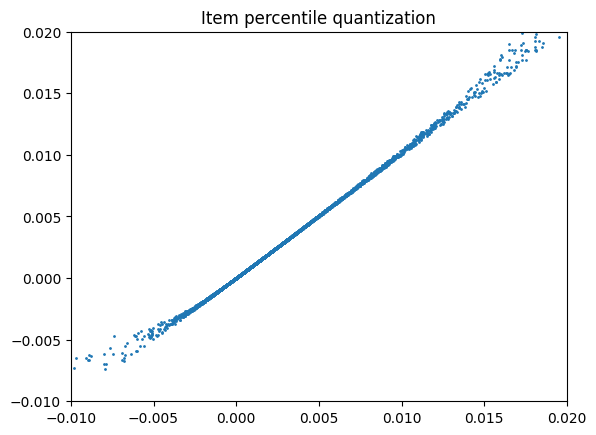

In [ ]:
# ideal plot: y = x
plt.scatter(item_factors[:100, :], perc_restore(perc_quantize(item_factors[:100, :], item_percentiles), item_percentiles), s=1)
plt.title("Item percentile quantization")
plt.xlim(-0.01, 0.02)
plt.ylim(-0.01, 0.02)

And for **users**:

In [ ]:
N = 100000
user_percentiles = []
for perc in tqdm_notebook(np.linspace(0, 100, 256)):
    user_percentiles.append(np.percentile(user_factors[:N, :], perc, axis=0))

<ipython-input-31-d62fbd4125be>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for perc in tqdm_notebook(np.linspace(0, 100, 256)):


  0%|          | 0/256 [00:00<?, ?it/s]

In [ ]:
user_percentiles = np.vstack(user_percentiles)

(-4.0, 4.0)

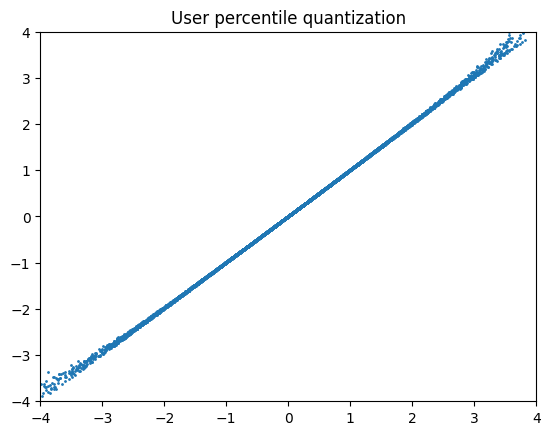

In [ ]:
# ideal plot: y = x
plt.scatter(user_factors[:100, :], perc_restore(perc_quantize(user_factors[:100, :], user_percentiles), user_percentiles), s=1)
plt.title("User percentile quantization")

plt.xlim(-4, 4)
plt.ylim(-4, 4)

Then we can check the overlap of quantized embeddings and original embeddings:

In [ ]:
overlaps = []
for user_idx in range(1, N, int(N/100)):
    scores1 = item_factors[:N].dot(user_factors[user_idx, :])
    scores2 = item_factors[:N].dot(
        perc_restore(
            perc_quantize(user_factors[user_idx:user_idx+1, :], user_percentiles),
            user_percentiles)[0])
    order1 = np.argsort(scores1)[::-1][:100]
    order2 = np.argsort(scores2)[::-1][:100]
    overlaps.append(len(set(order1) & set(order2)))
print("MEAN:", np.mean(overlaps))

MEAN: 88.8


### b. MinMax quantization

**Steps:**
1. **Range:**
   
   First, determine the range of values by calculating the 1st and 99th percentiles of the embedding values. These percentiles represent the lower and upper bounds of the data, respectively, and they define the range over which the data will be quantized.

2. **Quantize:**
   
   The quantization process scales the embedding values to a [0, 255] range. This is done by first normalizing the data within the defined range, then scaling it to fit the target range (0 to 255). Any values outside the range are clipped to ensure they fall within the [0, 255] bounds.

3. **Restore:**
   
   After quantization, the original values can be restored by reversing the scaling process. The quantized values are multiplied by a scaling factor and then shifted back by the lower bound. This restores the values to a continuous range similar to the original data.

**Quantization:** $q(x) = \frac{x - min}{max - min} \cdot 256$

**Restore:** $q^{-1}(x) = \frac{x(max - min)}{256} + min$


Let's start for **items**:

In [ ]:
item_low = np.percentile(item_factors[:N], 1, axis=0)
item_high = np.percentile(item_factors[:N], 99, axis=0)

item_step = (item_high - item_low + 1e-6) / 255.

In [ ]:
def mm_quantize(value, low, high):
    return (np.minimum(np.maximum((value - low) / (high - low + 1e-6), 0), 1) * 255).astype(np.uint8)

def mm_restore(q, l, s):
    return q.astype(np.float32) * s + l

(-0.01, 0.02)

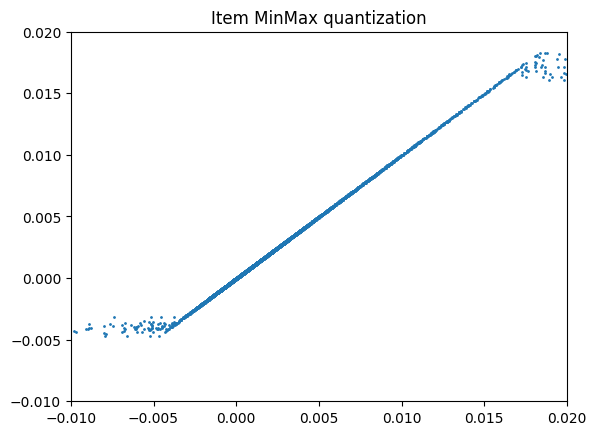

In [ ]:
plt.scatter(item_factors[0:100, :], mm_restore(mm_quantize(item_factors[0:100, :], item_low, item_high), item_low, item_step), s=1)
plt.title("Item MinMax quantization")

plt.xlim(-0.01, 0.02)
plt.ylim(-0.01, 0.02)

In [ ]:
overlaps = []
boo = mm_restore(mm_quantize(item_factors[:N], item_low, item_high), item_low, item_step)
for user_idx in range(1, N, int(N / 100)):
    scores1 = item_factors[:N].dot(user_factors[user_idx, :])
    scores2 = boo.dot(user_factors[user_idx, :])
    order1 = np.argsort(scores1)[::-1][:100]
    order2 = np.argsort(scores2)[::-1][:100]
    overlaps.append(len(set(order1) & set(order2)))
print("MEAN:", np.mean(overlaps))

MEAN: 67.24


And for **users**:

In [ ]:
user_low = np.percentile(user_factors[:N], 1, axis=0)
user_high = np.percentile(user_factors[:N], 99, axis=0)

user_step = (user_high - user_low + 1e-6) / 255.

(-4.0, 4.0)

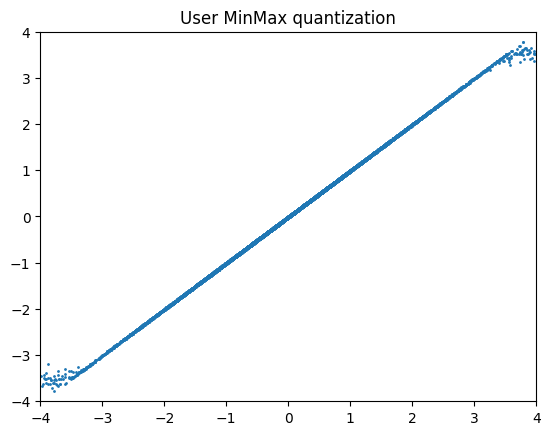

In [ ]:
plt.scatter(user_factors[0:100, :], mm_restore(mm_quantize(user_factors[0:100, :], user_low, user_high), user_low, user_step), s=1)
plt.title("User MinMax quantization")

plt.xlim(-4, 4)
plt.ylim(-4, 4)

In [ ]:
overlaps = []
for user_idx in range(1, N, int(N/100)):
    scores1 = item_factors[:N].dot(user_factors[user_idx, :])
    scores2 = item_factors[:N].dot(
        mm_restore(
            mm_quantize(user_factors[user_idx:user_idx+1, :], user_low, user_high),
            user_low, user_step)[0])
    order1 = np.argsort(scores1)[::-1][:100]
    order2 = np.argsort(scores2)[::-1][:100]
    overlaps.append(len(set(order1) & set(order2)))
print( "MEAN:", np.mean(overlaps))

MEAN: 94.9
